# HDA Project - CLL, FL, MCL Lymphoma Classification

Marco Chilese, Carlotta Segna 

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import keras, os, glob 

img_archive = "/content/gdrive/My Drive/HDA/lymphoma"

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


## Dataset split

--> Dataset came from: https://ome.grc.nia.nih.gov/iicbu2008/lymphoma/index.html

In [ ]:
import os
import numpy as np
import shutil
import random

# # Creating Train / Val / Test folders (One time use)
root_dir = img_archive + '/'
classes_dir = ['CLL', 'FL', 'MCL']

val_ratio = 0.25
test_ratio = 0.05

for cls in classes_dir:
    os.makedirs(root_dir +'train' + cls)
    os.makedirs(root_dir +'val' + cls)
    os.makedirs(root_dir +'test' + cls)


    # Creating partitions of the data after shuffeling
    src = root_dir + cls # Folder to copy images from

    allFileNames = os.listdir(src)
    np.random.shuffle(allFileNames)
    train_FileNames, val_FileNames, test_FileNames = np.split(np.array(allFileNames),
                                                              [int(len(allFileNames)* (1 - val_ratio + test_ratio)), 
                                                               int(len(allFileNames)* (1 - test_ratio))])


    train_FileNames = [src+'/'+ name for name in train_FileNames.tolist()]
    val_FileNames = [src+'/' + name for name in val_FileNames.tolist()]
    test_FileNames = [src+'/' + name for name in test_FileNames.tolist()]

    print('Total images: ', len(allFileNames))
    print('Training: ', len(train_FileNames))
    print('Validation: ', len(val_FileNames))
    print('Testing: ', len(test_FileNames))

    # Copy-pasting images
    for name in train_FileNames:
        shutil.copy(name, root_dir +'/train' + cls)

    for name in val_FileNames:
        shutil.copy(name, root_dir +'/val' + cls)

    for name in test_FileNames:
        shutil.copy(name, root_dir +'/test' + cls)

In [ ]:
files = glob.glob(os.path.join(img_archive+"/testCLL", "*.tif"))
files.extend(glob.glob(os.path.join(img_archive+"/testFL", "*.tif")))
files.extend(glob.glob(os.path.join(img_archive+"/testMCL", "*.tif")))

files.extend(glob.glob(os.path.join(img_archive+"/trainCLL", "*.tif")))
files.extend(glob.glob(os.path.join(img_archive+"/trainFL", "*.tif")))
files.extend(glob.glob(os.path.join(img_archive+"/trainMCL", "*.tif")))

files.extend(glob.glob(os.path.join(img_archive+"/valCLL", "*.tif")))
files.extend(glob.glob(os.path.join(img_archive+"/valFL", "*.tif")))
files.extend(glob.glob(os.path.join(img_archive+"/valMCL", "*.tif")))

In [ ]:
!pip3 install image_slicer
import image_slicer

for file in files:
  image_slicer.slice(file, 16)
  os.remove(file)

In [ ]:
#then update files in dir
files = glob.glob(os.path.join(img_archive+"/testCLL", "*.png"))
files.extend(glob.glob(os.path.join(img_archive+"/testFL", "*.png")))
files.extend(glob.glob(os.path.join(img_archive+"/testMCL", "*.png")))

files.extend(glob.glob(os.path.join(img_archive+"/trainCLL", "*.png")))
files.extend(glob.glob(os.path.join(img_archive+"/trainFL", "*.png")))
files.extend(glob.glob(os.path.join(img_archive+"/trainMCL", "*.png")))

files.extend(glob.glob(os.path.join(img_archive+"/valCLL", "*.png")))
files.extend(glob.glob(os.path.join(img_archive+"/valFL", "*.png")))
files.extend(glob.glob(os.path.join(img_archive+"/valMCL", "*.png")))

In [ ]:
import cv2
import numpy as np
from PIL import Image

batch_size=16
target_size=(224,224)

def myFunc(image):
    return cv2.cvtColor(image,cv2.COLOR_RGBA2BGR)

def color(x: tf.Tensor) -> tf.Tensor:
    x = tf.image.random_saturation(x, 0.6, 1.6)
    x = tf.image.random_contrast(x, 0.7, 1.3)
    return x

train_datagen = keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function = color,
        rescale=1./255,
      )

test_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        directory=img_archive + '/train',
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        directory=img_archive + '/val',
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical')

Found 4768 images belonging to 3 classes.
Found 896 images belonging to 3 classes.


Sample images from dataset

/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


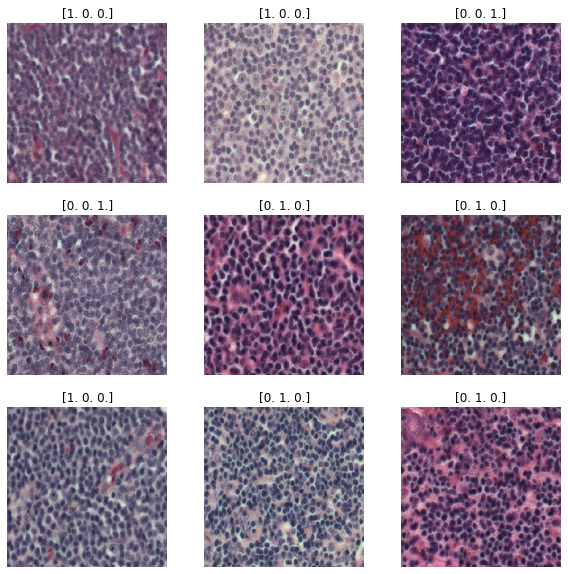

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 10))
for images, labels in validation_generator:
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(labels[i])
        plt.axis("off")
    break

## Models Definition

### Model from article 3

In [ ]:
import keras
import tensorflow as tf
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, Conv3D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam, RMSprop
from keras.losses import mae, sparse_categorical_crossentropy, binary_crossentropy

def modelFromArticle3(): #see Bib 
  model = Sequential([
                    Conv2D(20, kernel_size=5, activation="tanh", input_shape=(224, 224, 3)),
                    #BatchNormalization(),
                    Dropout(0.3),
                    MaxPooling2D((3, 3), strides=3, padding='same'),
                    
                    Conv2D(20, kernel_size=5, activation="tanh"),
                    #BatchNormalization(),
                    Dropout(0.3),
                    MaxPooling2D((3, 3), strides=3, padding='same'),

                    Conv2D(50, kernel_size=5, activation="tanh"),
                    #BatchNormalization(),
                    Dropout(0.3),
                    MaxPooling2D((3, 3), strides=3, padding='same'),

                    Conv2D(50, kernel_size=5, activation="tanh"),
                    #BatchNormalization(),
                    Dropout(0.3),
                    MaxPooling2D((3, 3), strides=3, padding='same'),
                    
                    Dense(500, activation="tanh"),
                    Dense(250, activation="tanh"),
                    Flatten(),
                    Dense(3, activation="softmax")
  ])
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
  model.summary()
  return model

### Model from article 1

In [ ]:
from keras import applications
from keras.models import Model

def modelFromArticle1():
  vgg_model = applications.VGG16(weights=None, include_top=False, input_shape=(224, 224, 3), pooling='max', classes=3)#, classifier_activation='softmax')

  # Creating dictionary that maps layer names to the layers
  layer_dict = dict([(layer.name, layer) for layer in vgg_model.layers])

  # Getting output tensor of the last VGG layer that we want to include
  x = layer_dict['block5_pool'].output

  # Stacking a new simple convolutional network on top of it    
  x = Flatten()(x)
  x = Dense(4096, activation="relu", name='fc1')(x)
  x = Dropout(0.5)(x)
  x = Dense(4096, activation="relu", name='fc2')(x)
  x = Dropout(0.5)(x)
  x = Dense(3, activation='softmax', name='predictions')(x)

  custom_model = Model(input=vgg_model.input, output=x)

  custom_model.summary()

  custom_model.compile(loss='categorical_crossentropy',
                      optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001, momentum=0.9),
                      metrics=['accuracy'])

  return custom_model

### AlexNet model

In [ ]:
 from keras.layers import Activation
 
 def alexNetModel():   
    model = Sequential()

    # 1st Convolutional Layer
    model.add(Conv2D(filters=96, input_shape=(224,224,3), kernel_size=(11,11), strides=(4,4), padding='valid'))
    model.add(Activation('relu'))
    # Max Pooling
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))

    # 2nd Convolutional Layer
    model.add(Conv2D(filters=256, kernel_size=(11,11), strides=(1,1), padding='valid'))
    model.add(Activation('relu'))
    # Max Pooling
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))

    # 3rd Convolutional Layer
    model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid'))
    model.add(Activation('relu'))

    # 4th Convolutional Layer
    model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid'))
    model.add(Activation('relu'))

    # 5th Convolutional Layer
    model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='valid'))
    model.add(Activation('relu'))
    # Max Pooling
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))

    # Passing it to a Fully Connected layer
    model.add(Flatten())
    # 1st Fully Connected Layer
    model.add(Dense(4096, input_shape=(224*224*3,)))
    model.add(Activation('relu'))
    # Add Dropout to prevent overfitting
    model.add(Dropout(0.4))

    # 2nd Fully Connected Layer
    model.add(Dense(4096))
    model.add(Activation('relu'))
    # Add Dropout
    model.add(Dropout(0.4))

    # 3rd Fully Connected Layer
    model.add(Dense(1000))
    model.add(Activation('relu'))
    # Add Dropout
    model.add(Dropout(0.4))

    # Output Layer
    model.add(Dense(3))
    model.add(Activation('softmax'))

    model.summary()

    # Compile the model
    model.compile(loss=keras.losses.categorical_crossentropy, optimizer='adam', metrics=['accuracy'])

    return model

### Our Model

In [ ]:
def ourModel(): 
  model = Sequential()
  model.add(Conv2D(filters = 16, kernel_size = 3, padding = 'same', activation = 'relu', input_shape = (224, 224, 3)))
  model.add(Dropout(0.3))
  model.add(MaxPooling2D(pool_size = 3))

  model.add(Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu'))
  model.add(Dropout(0.3))
  model.add(MaxPooling2D(pool_size = 3))

  model.add(Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu'))
  model.add(Dropout(0.3))
  model.add(MaxPooling2D(pool_size = 3))

  model.add(Conv2D(filters = 128, kernel_size = 3, padding = 'same', activation = 'relu'))
  model.add(Dropout(0.3))
  #model.add(MaxPooling2D(pool_size = 3))

  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.3))
  model.add(Dense(3, activation = 'softmax'))

  model.compile(optimizer=Adam(0.0001), loss=binary_crossentropy, metrics=['accuracy'])
  model.summary()
  return model

## Training

In [ ]:
model = modelFromArticle3()

epochs = 20
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=validation_generator.n//validation_generator.batch_size

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=12, restore_best_weights=True, verbose=1)

def scheduler(epoch):
  # This function keeps the learning rate at 0.001 for the first ten epochs
  # and decreases it exponentially after that.
  if epoch < 12:
    return 0.001
  else:
    return 0.001 * tf.math.exp(0.5 * (12 - epoch))

learning_rate_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

with tf.device('/GPU:0'):
  model_train  = model.fit(
      train_generator, epochs=epochs, validation_data=validation_generator,
      steps_per_epoch=STEP_SIZE_TRAIN, validation_steps=STEP_SIZE_VALID, callbacks=[early_stopping]#, learning_rate_scheduler]
  )

### Training evaluation

In [ ]:
import matplotlib.pyplot as plt

effective_len = len(model_train.history["accuracy"])
early_stopping_epoch = 15

plt.figure(figsize=(7, 7), dpi=80)
plt.subplot(2,1,1)
plt.title("Training History - Accuracy")
plt.plot(range(effective_len), model_train.history["accuracy"], label="accuracy", color="red")
plt.scatter(range(effective_len), model_train.history["val_accuracy"], label="val_accuracy")
#plt.axvline(early_stopping_epoch, 0, 1, label='early stopping', color="green")
plt.xticks(range(0,effective_len,5))
min_y = min(np.min(model_train.history["val_accuracy"]), np.min(model_train.history["accuracy"]))
plt.yticks(np.linspace(min_y-0.1,1,11))
plt.legend()


plt.subplot(2,1,2)
plt.title("Training History - Loss")
plt.plot(range(effective_len), model_train.history["val_loss"], label="val_loss", color="red")
plt.scatter(range(effective_len), model_train.history["loss"], label="loss")
#plt.axvline(early_stopping_epoch, 0, 1, label='early stopping', color="green")
plt.xticks(range(0,effective_len,5))
max_y = max(np.max(model_train.history["val_loss"]), np.max(model_train.history["loss"]))
plt.yticks(np.linspace(0,max_y+0.1,11))
plt.legend()

In [ ]:
model.save("/content/gdrive/My Drive/HDA/14_07_2020_model_90acc_article2.h5")

## Testing

In [ ]:
test_generator = test_datagen.flow_from_directory(
        directory=img_archive + '/test',
        target_size=target_size,
        class_mode='categorical')

Found 320 images belonging to 3 classes.


In [ ]:
my_model = tf.keras.models.load_model("/content/gdrive/My Drive/HDA/14_07_2020_model_90acc_article2.h5")

In [ ]:
test_eval = my_model.evaluate(test_generator) # [0] loss, [1] acc

print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1]*100, "%")

10/10 [==============================] - 137s 14s/step - loss: 0.1525 - accuracy: 0.9344
Test loss: 0.15245118737220764
Test accuracy: 93.4374988079071 %


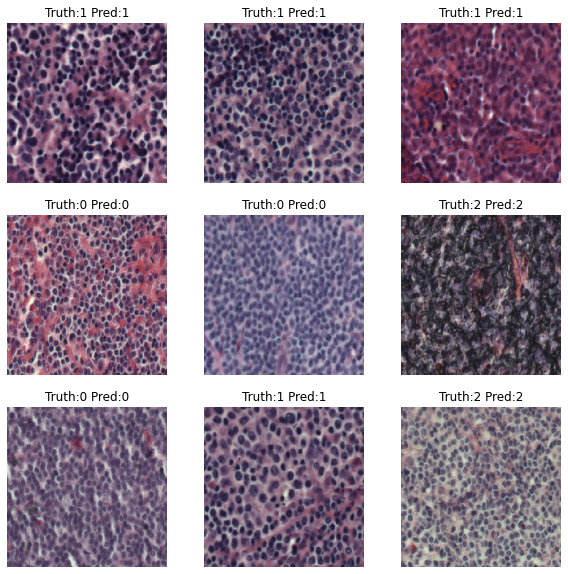

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 10))
for images, labels in test_generator:
    preds = my_model.predict(images)
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title("Truth:"+str(np.argmax(labels[i]))+" Pred:"+str(np.argmax(preds[i])))
        plt.axis("off")
    break

In [ ]:
with tf.device('/GPU:0'): 
  pred = my_model.predict(test_generator)

In [ ]:
pred = np.argmax(pred, axis=1)

In [ ]:
from sklearn.metrics import classification_report


target_names = ['CLL', 'FL', 'MCL']
print(classification_report(test_generator.classes, pred, target_names=target_names))

              precision    recall  f1-score   support

         CLL       0.33      0.29      0.30        91
          FL       0.41      0.46      0.43       112
         MCL       0.28      0.28      0.28        98

    accuracy                           0.35       301
   macro avg       0.34      0.34      0.34       301
weighted avg       0.34      0.35      0.34       301



### Comparison between models - Accuracy and Loss

Text(0, 0.5, '%')

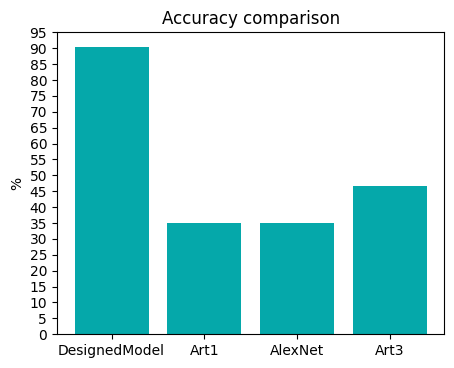

In [ ]:
plt.figure(figsize=(5, 4), dpi=100)
x = range(4)
plt.bar(x, height=[90.3, 34.9, 35.0, 46.6], color="#05A8AA")
plt.title("Accuracy comparison")
plt.xticks(x, ['DesignedModel','Art1','AlexNet', "Art3"])
plt.yticks(range(0,100,5))
plt.ylabel("%")

([<matplotlib.axis.YTick at 0x7f425308f198>,
 <a list of 10 Text major ticklabel objects>)

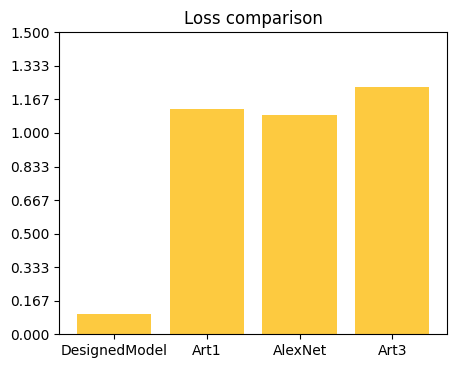

In [ ]:
plt.figure(figsize=(5, 4), dpi=100)
x = range(4)
plt.bar(x, height=[0.10, 1.12, 1.09, 1.23], color="#FDCA40")
plt.title("Loss comparison")
plt.xticks(x, ['DesignedModel','Art1','AlexNet', "Art3"])
plt.yticks(np.linspace(0,1.5,num=10))

## Bibliography (in LaTeX style)

**article 3**<br>
@article{el2019automated, title={Automated diagnosis of lymphoma with digital pathology images using deep learning}, author={El Achi, Hanadi and Belousova, Tatiana and Chen, Lei and Wahed, Amer and Wang, Iris and Hu, Zhihong and Kanaan, Zeyad and Rios, Adan and Nguyen, Andy ND}, journal={Annals of Clinical \& Laboratory Science}, volume={49}, number={2}, pages={153--160}, year={2019}, publisher={Assoc Clin Scientists} }


**article 1**<br>
@article{10.1371/journal.pone.0213626, author = {Oei, Ronald Wihal AND Hou, Guanqun AND Liu, Fuhai AND Zhong, Jin AND Zhang, Jiewen AND An, Zhaoyi AND Xu, Luping AND Yang, Yujiu}, journal = {PLOS ONE}, publisher = {Public Library of Science}, title = {Convolutional neural network for cell classification using microscope images of intracellular actin networks}, year = {2019}, month = {03}, volume = {14}, url = {https://doi.org/10.1371/journal.pone.0213626}, pages = {1-13}, number = {3}, doi = {10.1371/journal.pone.0213626} }

**AlexNet**<br>
@inproceedings{krizhevsky2012imagenet,
  title={Imagenet classification with deep convolutional neural networks},
  author={Krizhevsky, Alex and Sutskever, Ilya and Hinton, Geoffrey E},
  booktitle={Advances in neural information processing systems},
  pages={1097--1105},
  year={2012}
}